## &#x1F310; &nbsp; Code Library, Style, and Links
The previous notebooks:

&#x1F310; &nbsp; [PASSNYC. Data Exploration](https://www.kaggle.com/olgabelitskaya/passnyc-data-exploration)

&#x1F310; &nbsp; [PASSNYC. Numeric and Categorical Variables](https://www.kaggle.com/olgabelitskaya/passnyc-numeric-and-categorical-variables)

&#x1F310; &nbsp; [PASSNYC. Comparing All Districts with 5th District](passnyc-comparing-all-districts-with-5th-district)

&#x1F310; &nbsp; [PASSNYC. Regression Methods](https://www.kaggle.com/olgabelitskaya/passnyc-regression-methods)

In [8]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #37c9e1; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #aaa;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}               
</style>

In [19]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from descartes import PolygonPatch

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score

from keras.models import Sequential, load_model, Model
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding

from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint

In [34]:
def scores(regressor, y_train, y_valid, y_test, y_train_reg, y_valid_reg, y_test_reg):
    print("_______________________________________")
    print(regressor)
    print("_______________________________________")
    print("EV score. Train: ", explained_variance_score(y_train, y_train_reg))
    print("EV score. Valid: ", explained_variance_score(y_valid, y_valid_reg))
    print("EV score. Test: ", explained_variance_score(y_test, y_test_reg))
    print("---------")
    print("R2 score. Train: ", r2_score(y_train, y_train_reg))
    print("R2 score. Valid: ", r2_score(y_valid, y_valid_reg))
    print("R2 score. Test: ", r2_score(y_test, y_test_reg))
    print("---------")
    print("MSE score. Train: ", mean_squared_error(y_train, y_train_reg))
    print("MSE score. Valid: ", mean_squared_error(y_valid, y_valid_reg))
    print("MSE score. Test: ", mean_squared_error(y_test, y_test_reg))
    print("---------")
    print("MAE score. Train: ", mean_absolute_error(y_train, y_train_reg))
    print("MAE score. Valid: ", mean_absolute_error(y_valid, y_valid_reg))
    print("MAE score. Test: ", mean_absolute_error(y_test, y_test_reg))
    print("---------")
    print("MdAE score. Train: ", median_absolute_error(y_train, y_train_reg))
    print("MdAE score. Valid: ", median_absolute_error(y_valid, y_valid_reg))
    print("MdAE score. Test: ", median_absolute_error(y_test, y_test_reg))
    
def loss_plot(fit_history, n):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['loss'][n:], 
             color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], 
             color='#37c9e1', label = 'valid')

    plt.legend()
    plt.title('Loss Function');  
    
def mae_plot(fit_history, n):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['mean_absolute_error'][n:], 
             color='slategray', label = 'train')
    plt.plot(fit_history.history['val_mean_absolute_error'][n:], 
             color='#37c9e1', label = 'valid')

    plt.legend()
    plt.title('Mean Absolute Error');

In [3]:
style_dict = {'background-color':'slategray',
              'color':'#37c9e1'}

## &#x1F310; &nbsp; Load and Preprocess the Data

In [4]:
school_explorer = pd.read_csv('2016 School Explorer.csv')
d5_shsat = pd.read_csv('D5 SHSAT Registrations and Testers.csv')
school_explorer.shape, d5_shsat.shape

((1272, 161), (140, 7))

In [5]:
# Fillna or replace values
numeric_list = list(school_explorer\
.columns[[7,8]+list(range(16,27))+[28,30,32,34,36]+list(range(41,161))])
target_list = ['Average ELA Proficiency','Average Math Proficiency']

school_explorer = school_explorer.drop(['Adjusted Grade',
                                        'New?',
                                        'Other Location Code in LCGMS'], 
                                       axis=1)
school_explorer.loc[[427,1023,712,908],'School Name'] = \
['P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27']

percent_list = ['Percent ELL','Percent Asian','Percent Black',
                'Percent Hispanic','Percent Black / Hispanic',
                'Percent White','Student Attendance Rate',
                'Percent of Students Chronically Absent',
                'Rigorous Instruction %','Collaborative Teachers %',
                'Supportive Environment %','Effective School Leadership %',
                'Strong Family-Community Ties %','Trust %']

for el in percent_list:
    school_explorer[el] = school_explorer[el].astype('str')
    school_explorer[el] = school_explorer[el].str.replace("%", "")
    school_explorer[el] = school_explorer[el].str.replace("nan", "0")
    school_explorer[el] = school_explorer[el].astype(float)
    school_explorer[el].replace(0, np.NaN, inplace=True)
    school_explorer[el] = school_explorer[el].interpolate()
    
school_explorer['Economic Need Index'] = \
school_explorer['Economic Need Index'].interpolate()
school_explorer['Average ELA Proficiency'] = \
school_explorer['Average ELA Proficiency'].interpolate()
school_explorer['Average Math Proficiency'] = \
school_explorer['Average Math Proficiency'].interpolate()

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype('str') 
for s in [",","$"," "]:
    school_explorer['School Income Estimate'] = \
    school_explorer['School Income Estimate'].str.replace(s, "")
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].str.replace("nan", "0")

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype(float)
school_explorer['School Income Estimate'].replace(0, np.NaN, inplace=True)
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].interpolate()

rating_list = ['Rigorous Instruction Rating','Collaborative Teachers Rating',
               'Supportive Environment Rating','Effective School Leadership Rating',
               'Strong Family-Community Ties Rating','Strong Family-Community Ties Rating',
               'Trust Rating','Student Achievement Rating']

for el in rating_list:
    moda_value = school_explorer[el].value_counts().idxmax()
    school_explorer[el] = school_explorer[el].fillna(moda_value) 
    
category_list1 = ['District','Community School?','City','Grades']
                  
category_list2 = ['Rigorous Instruction Rating',
                  'Collaborative Teachers Rating',
                  'Supportive Environment Rating',
                  'Effective School Leadership Rating',
                  'Strong Family-Community Ties Rating',
                  'Trust Rating','Student Achievement Rating']

for feature in category_list1:
    feature_cat = pd.factorize(school_explorer[feature])
    school_explorer[feature] = feature_cat[0]
    
for feature in category_list2:
    feature_pairs = dict(zip(['Not Meeting Target', 'Meeting Target', 
                              'Approaching Target', 'Exceeding Target'],
                             ['0','2','1','3']))
    school_explorer[feature].replace(feature_pairs,inplace=True)
    school_explorer[feature] = school_explorer[feature].astype(int)
    
category_list = list(category_list1+category_list2)
    
print('NaN count = ', sum(school_explorer.isna().sum()))  

NaN count =  0


In [6]:
# Merge two datasets
d5_shsat_2016 = d5_shsat[['DBN','Number of students who registered for the SHSAT',
                          'Number of students who took the SHSAT']][d5_shsat['Year of SHST']==2016]\
.groupby(['DBN'],as_index=False).agg(np.sum)

d5_shsat_2016['Took SHSAT %'] = d5_shsat_2016['Number of students who took the SHSAT']\
/d5_shsat_2016['Number of students who registered for the SHSAT']

d5_shsat_2016['Took SHSAT %'] = d5_shsat_2016['Took SHSAT %'].fillna(0).apply(lambda x: round(x,3))
d5_shsat_2016.rename(columns={'DBN':'Location Code'}, inplace=True)

d5_shsat_2016 = pd.merge(school_explorer[['Location Code']+numeric_list+target_list],
                         d5_shsat_2016, 
                         on='Location Code')
d5_shsat_2016.shape

(21, 144)

## &#x1F310; &nbsp; Split the Data for Neural Networks Training
The predictions of economic indicators for schools are based on the data about social environment, ethnic composition and educational results.

#### The first set of features

In [37]:
# data = school_explorer
# features = numeric veriables+target_list-economic_indicators, targets = Economic Need Index
features = school_explorer[numeric_list+target_list]\
.drop(['Economic Need Index','School Income Estimate'], axis=1).values
targets = school_explorer['Economic Need Index'].values

X_train1, X_test1, y_train1, y_test1 = \
train_test_split(features, targets, test_size=0.3, random_state=1)

n = int(len(X_test1)/2)
X_valid1, y_valid1 = X_test1[:n], y_test1[:n]
X_test1, y_test1 = X_test1[n:], y_test1[n:]
X_train1.shape, X_test1.shape, X_valid1.shape, y_train1.shape, y_test1.shape, y_valid1.shape

((890, 138), (191, 138), (191, 138), (890,), (191,), (191,))

#### The second set of features

In [38]:
# data = school_explorer
# features = numeric veriables+target_list-economic_indicators, targets = School Income Estimate
features = school_explorer[numeric_list+target_list]\
.drop(['Economic Need Index','School Income Estimate'], axis=1).values
targets = school_explorer['School Income Estimate'].values

X_train2, X_test2, y_train2, y_test2 = \
train_test_split(features, targets, test_size=0.3, random_state=1)

n = int(len(X_test2)/2)
X_valid2, y_valid2 = X_test2[:n], y_test2[:n]
X_test2, y_test2 = X_test2[n:], y_test2[n:]
X_train2.shape, X_test2.shape, X_valid2.shape, y_train2.shape, y_test2.shape, y_valid2.shape

((890, 138), (191, 138), (191, 138), (890,), (191,), (191,))

## &#x1F310; &nbsp; Neural Network Regressors
### MLP
#### The first set of features

In [47]:
def mlp_model1():
    model = Sequential()
    
    model.add(Dense(138, input_dim=138))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(138*8))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138*8))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

mlp_model1 = mlp_model1()

In [48]:
mlp_checkpointer1 = ModelCheckpoint(filepath='mlp_model1.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
mlp_lr_reduction1 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.1)

In [49]:
mlp_history1 = mlp_model1.fit(X_train1, y_train1, 
                              epochs=35, batch_size=64, verbose=2,
                              validation_data=(X_valid1, y_valid1),
                              callbacks=[mlp_checkpointer1,mlp_lr_reduction1])

Train on 890 samples, validate on 191 samples
Epoch 1/35
 - 1s - loss: 7107.8187 - mean_absolute_error: 26.0676 - val_loss: 11.3594 - val_mean_absolute_error: 3.0481

Epoch 00001: val_loss improved from inf to 11.35943, saving model to mlp_model1.passnyc.hdf5
Epoch 2/35
 - 0s - loss: 31.1538 - mean_absolute_error: 4.5519 - val_loss: 9.9296 - val_mean_absolute_error: 2.9634

Epoch 00002: val_loss improved from 11.35943 to 9.92960, saving model to mlp_model1.passnyc.hdf5
Epoch 3/35
 - 0s - loss: 27.0614 - mean_absolute_error: 3.9291 - val_loss: 103.9833 - val_mean_absolute_error: 8.9930

Epoch 00003: val_loss did not improve from 9.92960
Epoch 4/35
 - 0s - loss: 20.3127 - mean_absolute_error: 2.6967 - val_loss: 2.9420 - val_mean_absolute_error: 1.5763

Epoch 00004: val_loss improved from 9.92960 to 2.94195, saving model to mlp_model1.passnyc.hdf5
Epoch 5/35
 - 0s - loss: 16.7811 - mean_absolute_error: 2.9219 - val_loss: 4.9902 - val_mean_absolute_error: 1.5694

Epoch 00005: val_loss did 

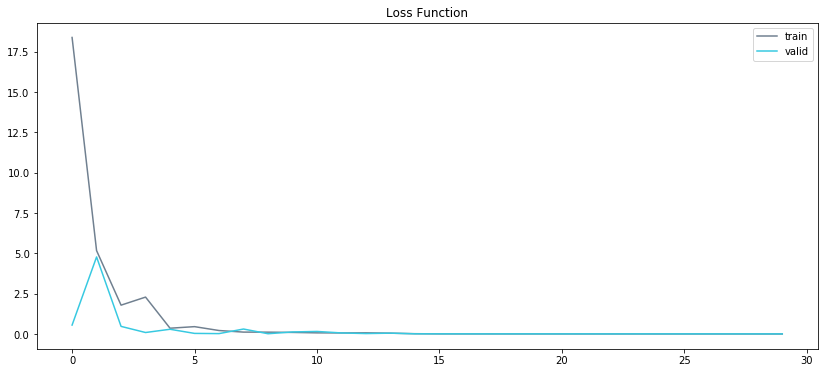

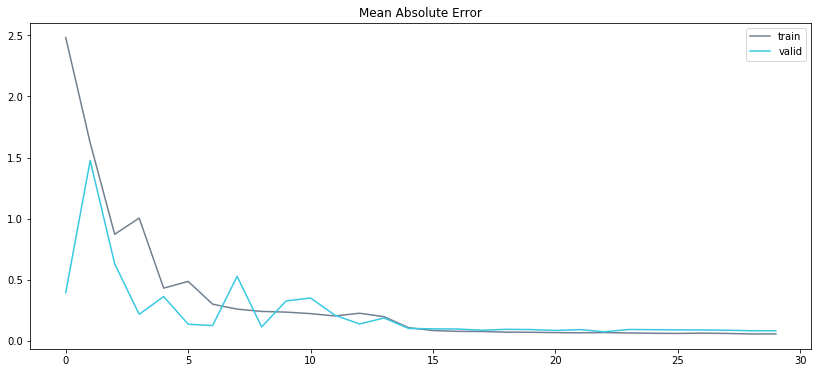

In [50]:
loss_plot(mlp_history1,5)
mae_plot(mlp_history1,5)

In [51]:
mlp_model1.load_weights('mlp_model1.passnyc.hdf5')

y_train_mlp1 = mlp_model1.predict(X_train1)
y_valid_mlp1 = mlp_model1.predict(X_valid1)
y_test_mlp1 = mlp_model1.predict(X_test1)

scores('MLP; Economic Need Index', 
       y_train1, y_valid1, y_test1, y_train_mlp1, y_valid_mlp1, y_test_mlp1)

_______________________________________
MLP; Economic Need Index
_______________________________________
EV score. Train:  0.8763279269573927
EV score. Valid:  0.8056372966397766
EV score. Test:  0.7640083544137508
---------
R2 score. Train:  0.8743824322084917
R2 score. Valid:  0.8050620681444952
R2 score. Test:  0.7630214788552201
---------
MSE score. Train:  0.005293868639277571
MSE score. Valid:  0.010115094178608779
MSE score. Test:  0.010337615750766901
---------
MAE score. Train:  0.05590035007807646
MAE score. Valid:  0.07434087941183158
MAE score. Test:  0.07548642137755898
---------
MdAE score. Train:  0.04377669405937201
MdAE score. Valid:  0.055610644817352284
MdAE score. Test:  0.05515877771377564


#### The second set of features

In [52]:
def mlp_model2():
    model = Sequential()
    
    model.add(Dense(138, input_dim=138))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(138*8))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138*8))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

mlp_model2 = mlp_model2()

In [53]:
mlp_checkpointer2 = ModelCheckpoint(filepath='mlp_model2.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
mlp_lr_reduction2 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.1)

In [55]:
mlp_history2 = mlp_model2.fit(X_train2, y_train2, 
                              epochs=35, batch_size=64, verbose=2,
                              validation_data=(X_valid2, y_valid2),
                              callbacks=[mlp_checkpointer2,mlp_lr_reduction2])

Train on 890 samples, validate on 191 samples
Epoch 1/35
 - 1s - loss: 1210110458.5348 - mean_absolute_error: 26455.2474 - val_loss: 504321425.0890 - val_mean_absolute_error: 15197.4786

Epoch 00001: val_loss improved from inf to 504321425.08901, saving model to mlp_model2.passnyc.hdf5
Epoch 2/35
 - 0s - loss: 422221132.8000 - mean_absolute_error: 15077.1990 - val_loss: 402741575.0366 - val_mean_absolute_error: 13478.2230

Epoch 00002: val_loss improved from 504321425.08901 to 402741575.03665, saving model to mlp_model2.passnyc.hdf5
Epoch 3/35
 - 0s - loss: 332014954.8584 - mean_absolute_error: 13439.7539 - val_loss: 326759193.1309 - val_mean_absolute_error: 13968.3357

Epoch 00003: val_loss improved from 402741575.03665 to 326759193.13089, saving model to mlp_model2.passnyc.hdf5
Epoch 4/35
 - 0s - loss: 292512011.6494 - mean_absolute_error: 12872.7286 - val_loss: 274062614.7853 - val_mean_absolute_error: 12567.9727

Epoch 00004: val_loss improved from 326759193.13089 to 274062614.7853

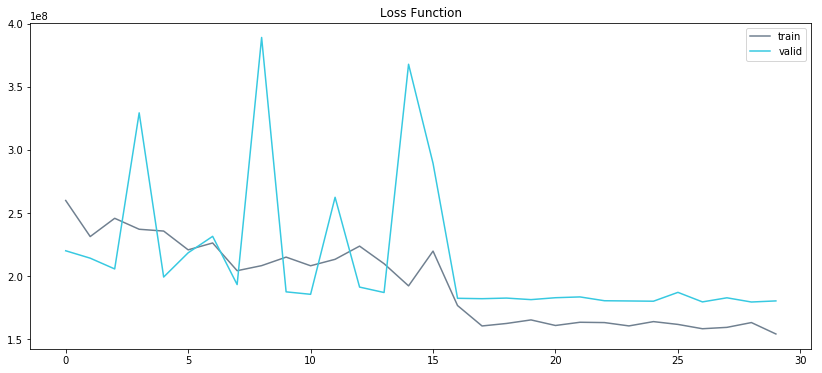

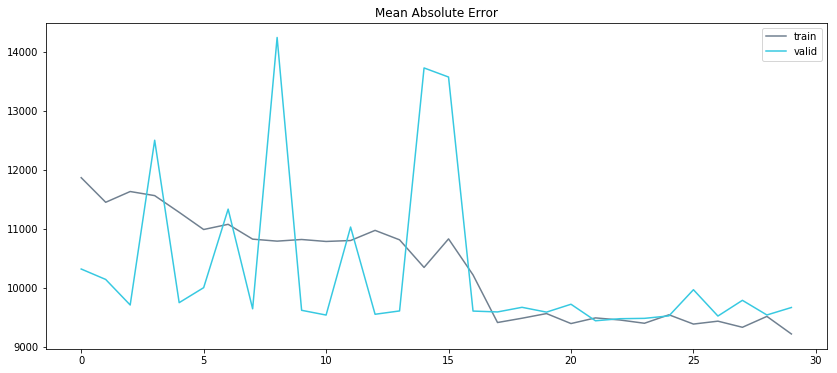

In [56]:
loss_plot(mlp_history2,5)
mae_plot(mlp_history2,5)

In [57]:
mlp_model2.load_weights('mlp_model2.passnyc.hdf5')

y_train_mlp2 = mlp_model2.predict(X_train2)
y_valid_mlp2 = mlp_model2.predict(X_valid2)
y_test_mlp2 = mlp_model2.predict(X_test2)

scores('MLP; School Income Estimate', 
       y_train2, y_valid2, y_test2, y_train_mlp2, y_valid_mlp2, y_test_mlp2)

_______________________________________
MLP; School Income Estimate
_______________________________________
EV score. Train:  0.6488275841314393
EV score. Valid:  0.6502580453534286
EV score. Test:  0.5946482093719807
---------
R2 score. Train:  0.6479330865046751
R2 score. Valid:  0.6502310875336996
R2 score. Test:  0.5941727752819342
---------
MSE score. Train:  153485759.16886923
MSE score. Valid:  179398281.042733
MSE score. Test:  159216381.42940935
---------
MAE score. Train:  9140.634333290089
MAE score. Valid:  9540.868868844344
MAE score. Test:  9746.050438858478
---------
MdAE score. Train:  7001.370117187502
MdAE score. Valid:  7597.4820312500015
MdAE score. Test:  8368.498124999998
